In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

import utils as ut
from IPython.display import display

In [2]:
with open('../config/algos_repo.json', 'r') as f:
    config = json.load(f)

df_defs = None

obj = config['resources']['structure_learning_algorithms']
for alg in obj:
    try:
        df = pd.read_csv(f'../backups/run5/{alg}.csv')
    except:
        continue

    print(alg)
    params = list(obj[alg][0].keys())

    df_def = ut.best_all(df, params)
    df_def['id'] = df['id'].unique()[0]
    df_defs = pd.concat([df_defs, df_def], ignore_index=True)

pcalg_pc
tetrad_fges
tetrad_fci
gcastle_ica_lingam
gcastle_anm
cdt_cam
gcastle_notears


In [3]:
bench_all = pd.read_csv('../backups/run5/joint_benchmarks.csv', index_col=0)
df_best = ut.best_h(bench_all).groupby(['id', 'graph_p', 'graph_d', 'graph_type', 'data_sem', 'data_n'], as_index=False)['SHD_pattern'].agg(['mean', 'sem']).reset_index()
df_worst = ut.worst_h(bench_all).groupby(['id', 'graph_p', 'graph_d', 'graph_type', 'data_sem', 'data_n'], as_index=False)['SHD_pattern'].agg(['mean', 'sem']).reset_index()

/home/damian/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (25,27,28,29,30,31,33,34,38,39,40,45,46,47,48,49,51) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Plots

In [7]:
df_best_plt = df_best.rename(columns={'mean': 'SHD'}).drop(columns=['sem'])
df_best_plt['quality'] = 'best'

df_worst_plt = df_worst.rename(columns={'mean': 'SHD'}).drop(columns=['sem'])
df_worst_plt['quality'] = 'worst'

df_defs_plt = df_defs.rename(columns={'SHD_mean': 'SHD'}).drop(columns=['SHD_sem'])
df_defs_plt['quality'] = 'default'

df_final = pd.concat([df_best_plt, df_defs_plt, df_worst_plt], axis=0)

df_final['graph'] = df_final.apply(lambda x: f"{x['graph_type'].upper()}{x['graph_d']}", axis=1)

In [5]:
def select_1(df, s, n):
    if s == 'gumbel':
        return df.loc[(df['data_sem'] == s) & (df['data_n'] == n) & (df['id'] != 'anm')]
    else:
        return df.loc[(df['data_sem'] == s) & (df['data_n'] == n)]
    
def select_2(df, s, d):
    if s == 'gumbel':
        return df.loc[(df['data_sem'] == s) & (df['graph_d'] == d) & (df['id'] != 'anm')]
    else:
        return df.loc[(df['data_sem'] == s) & (df['graph_d'] == d)]

SEM = gp, d = 1


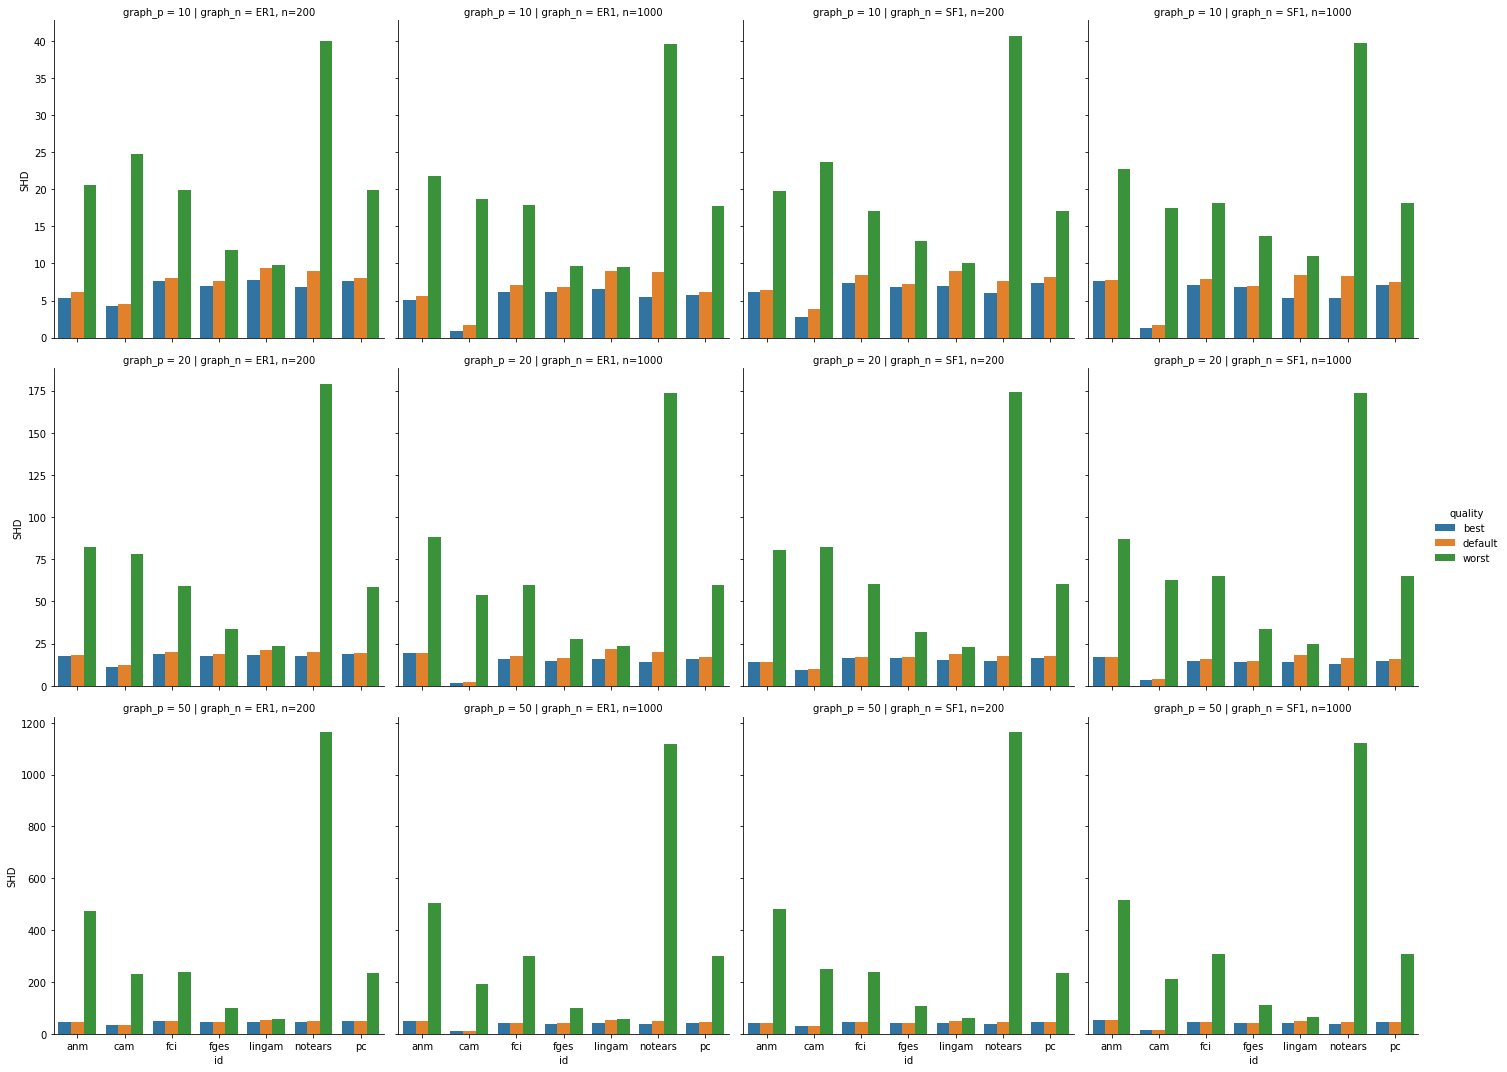

SEM = gp, d = 4


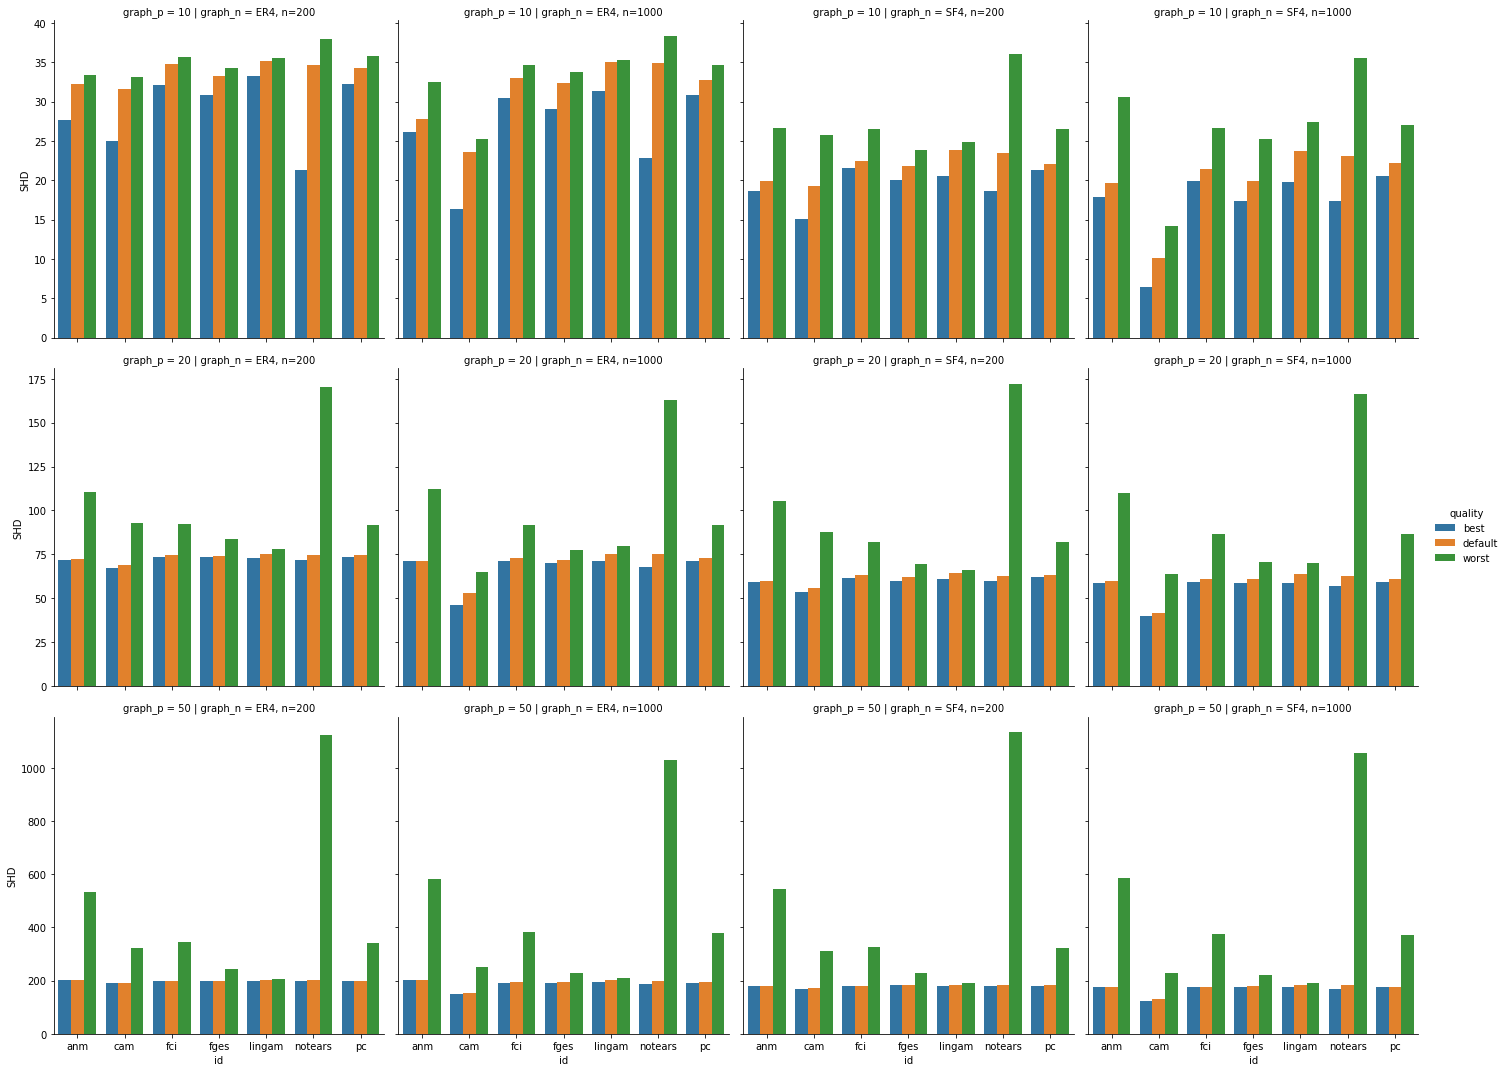

SEM = gumbel, d = 1


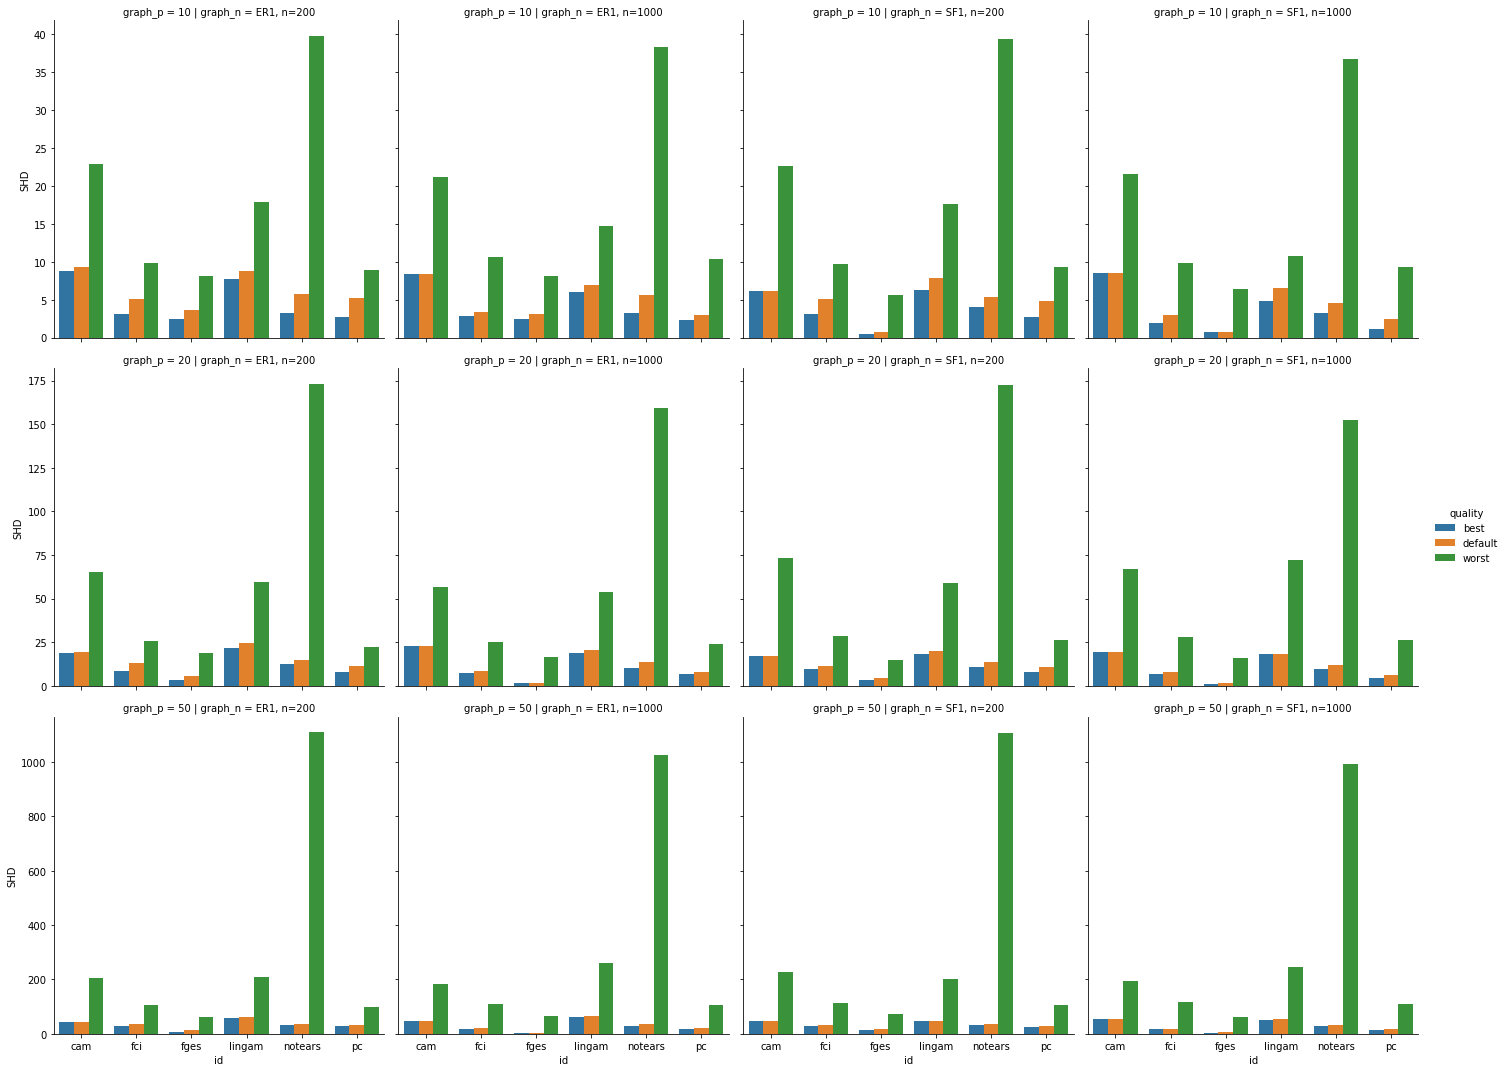

SEM = gumbel, d = 4


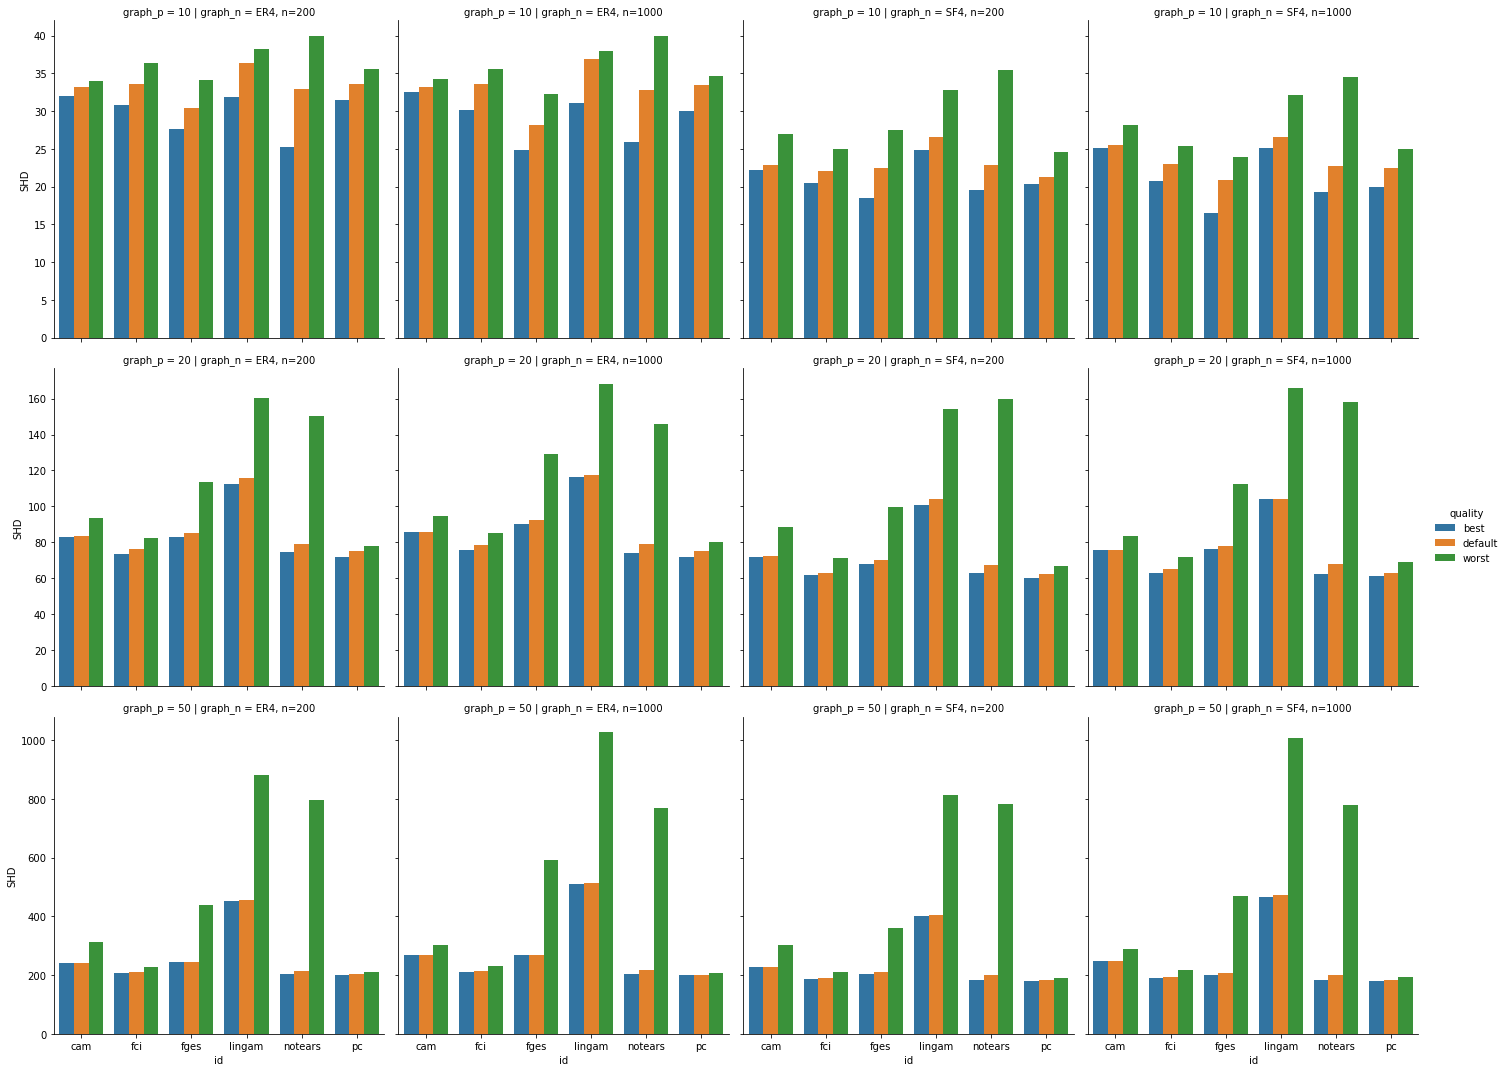

In [8]:
df_plt = df_final.copy()
df_plt['graph_n'] = df_plt.apply(lambda x: f"{x['graph']}, n={x['data_n']}", axis=1)

for sem in ['gp', 'gumbel']:
    for d in [1, 4]:
        print(f'SEM = {sem}, d = {d}')
        df1 = select_2(df_plt, sem, d)
        #sns.catplot(data=df1, x='id', y='SHD', col='graph_n', row='graph_p', hue='quality', kind='bar', ci=None, sharey=True)
        sns.catplot(data=df1, x='id', y='SHD', col='graph_n', row='graph_p', hue='quality', kind='bar', ci=None, sharey='row')
        plt.show()

## Tables

In [9]:
df_best['best'] = df_best.apply(lambda x: f"{x['mean']} ({x['sem']:.2f})", axis=1)
df_best.drop(columns=['sem'], inplace=True)

df_defs['default'] = df_defs.apply(lambda x: f"{x['SHD_mean']} ({x['SHD_sem']:.2f})", axis=1)

df_worst['worst'] = df_worst.apply(lambda x: f"{x['mean']} ({x['sem']:.2f})", axis=1)
df_worst.drop(columns=['sem'], inplace=True)

merge_key = ['id', 'graph_p', 'graph_d', 'graph_type', 'data_sem', 'data_n']
df_final = df_best.merge(df_defs, on=merge_key).merge(df_worst, on=merge_key)

df_final['graph_type_d'] = df_final.apply(lambda x: f"{x['graph_type'].upper()}{x['graph_d']}", axis=1)
df_final['id'] = df_final.apply(lambda x: x['id'].upper(), axis=1)

In [10]:
def select(df, gtd, p, sem, n):
    return df.loc[(df['graph_type_d'] == gtd) & (df['data_sem'] == sem) & (df['data_n'] == n) & (df['graph_p'] == p), ['id', 'best', 'default', 'worst']]

def select_across_n(df, gt, d, p, sem):
    gtd = f'{gt.upper()}{d}'
    df1 = select(df, gtd, p, sem, 200).merge(select(df, gtd, p, sem, 1000), on='id', suffixes=['_200', '_1000'])

    df1.set_index('id', inplace=True)

    df1.columns = pd.MultiIndex.from_tuples([(f"n={c.split('_')[1]}", c.split('_')[0]) for c in df1.columns])

    return df1

def create_mi(df, p):
    return pd.MultiIndex.from_tuples([(p, c) for c in df.columns])

def select_across_p(df, gt, d, n, sem):
    gtd = f'{gt.upper()}{d}'
    df10 = select(df, gtd, 10, sem, n).set_index('id')
    df20 = select(df, gtd, 20, sem, n).set_index('id')
    df50 = select(df, gtd, 50, sem, n).set_index('id')

    for dfx, p in zip([df10, df20, df50], [10, 20, 50]):
        dfx.columns = create_mi(dfx, f'p={p}')

    return df10.merge(df20, on='id').merge(df50, on='id')

### Across n

In [11]:
for gt in ['er', 'sf']:
    for d in [1, 4]:
        for sem in ['gumbel', 'gp']:
            for p in [10, 20, 50]:
                print()
                print('='*30)
                print(f"{gt.upper()}{d}, {sem}, p={p}")
                display(select_across_n(df_final, gt, d, p, sem))
                print()


ER1, gumbel, p=10


n=200                                 n=1000               \
                best      default        worst         best      default   
id                                                                         
ANM      11.6 (1.41)  11.8 (1.37)  21.6 (1.31)  11.8 (1.78)  12.3 (1.78)   
CAM       8.8 (0.92)   9.3 (1.05)  22.9 (1.37)   8.4 (0.92)   8.4 (0.92)   
FCI       3.1 (0.82)   5.1 (0.94)   9.8 (0.70)   2.9 (0.92)   3.4 (0.83)   
FGES      2.5 (1.05)   3.6 (1.11)   8.1 (1.44)   2.5 (1.07)   3.1 (1.35)   
LINGAM    7.7 (1.31)   8.8 (1.44)  17.9 (2.33)   6.0 (1.58)   6.9 (1.54)   
NOTEARS   3.3 (0.45)   5.7 (0.76)  39.8 (0.65)   3.2 (0.71)   5.6 (0.82)   
PC        2.7 (0.79)   5.2 (0.89)   8.9 (0.72)   2.3 (0.79)   3.0 (0.71)   

                      
               worst  
id                    
ANM      21.3 (1.14)  
CAM      21.1 (1.26)  
FCI      10.6 (1.28)  
FGES      8.1 (1.43)  
LINGAM   14.7 (3.13)  
NOTEARS  38.3 (0.56)  
PC       10.3 (1.36)



ER1, gumbel, p=20


n=200                                  n=1000               \
                best      default         worst         best      default   
id                                                                          
ANM      47.8 (5.87)  47.9 (5.90)   92.7 (4.56)  54.4 (7.62)  54.7 (7.61)   
CAM      19.0 (2.04)  19.1 (2.04)   65.2 (2.05)  23.0 (2.56)  23.0 (2.56)   
FCI       8.4 (1.11)  13.1 (1.78)   25.5 (1.60)   7.1 (1.67)   8.3 (1.81)   
FGES      3.2 (1.06)   5.7 (1.74)   19.0 (2.07)   1.8 (0.90)   1.8 (0.90)   
LINGAM   21.4 (1.33)  24.4 (1.83)   59.5 (3.63)  19.0 (2.12)  20.4 (2.38)   
NOTEARS  12.5 (1.75)  15.0 (1.81)  173.3 (2.39)  10.4 (1.87)  13.5 (1.65)   
PC        8.0 (0.91)  11.2 (1.50)   22.3 (1.67)   6.9 (1.45)   7.8 (1.44)   

                       
                worst  
id                     
ANM       87.1 (5.19)  
CAM       56.6 (1.61)  
FCI       25.2 (1.57)  
FGES      16.3 (2.21)  
LINGAM    53.9 (6.34)  
NOTEARS  159.5 (3.42)  
PC        23.7 (1.42)



ER1, gumbel, p=50


n=200                                       n=1000  \
                  best        default          worst           best   
id                                                                    
ANM      155.2 (15.38)  155.2 (15.38)  497.9 (11.39)  200.3 (23.35)   
CAM        43.5 (4.81)    43.5 (4.81)   205.2 (4.10)    48.6 (4.10)   
FCI        29.7 (1.56)    34.6 (2.02)   105.0 (5.35)    18.6 (2.30)   
FGES        8.1 (1.21)    12.6 (1.61)    63.2 (2.08)     2.4 (0.90)   
LINGAM     59.1 (4.20)    60.6 (4.19)  210.2 (19.22)    60.0 (3.65)   
NOTEARS    32.0 (3.22)    34.8 (2.81)  1112.1 (8.18)    29.2 (3.04)   
PC         27.3 (1.09)    31.4 (1.45)    98.0 (6.18)    16.6 (2.66)   

                                        
               default           worst  
id                                      
ANM      200.4 (23.37)   500.4 (16.76)  
CAM        48.6 (4.10)    182.1 (6.54)  
FCI        20.5 (2.38)    110.3 (6.91)  
FGES        3.5 (1.11)     63.9 (2.84)  
LINGAM     64.3 (3.43)   260.4 (17.95)  
NOTEARS    34.9 (2.79)  1026.0 (13.90)  
PC         19.9 (3.01)    104.8 (7.15)



ER1, gp, p=10


n=200                               n=1000              \
               best     default        worst        best     default   
id                                                                     
ANM      5.3 (0.79)  6.1 (0.72)  20.6 (1.40)  5.1 (0.71)  5.6 (0.85)   
CAM      4.3 (1.01)  4.5 (1.00)  24.7 (1.21)  0.9 (0.38)  1.7 (0.65)   
FCI      7.6 (0.76)  8.1 (0.78)  19.9 (0.67)  6.2 (0.59)  7.1 (0.77)   
FGES     7.0 (0.77)  7.6 (0.73)  11.8 (0.96)  6.1 (0.69)  6.8 (0.57)   
LINGAM   7.8 (0.76)  9.4 (0.67)   9.8 (0.81)  6.6 (0.56)  9.0 (0.70)   
NOTEARS  6.8 (0.57)  9.0 (0.67)  39.9 (1.02)  5.5 (0.65)  8.8 (0.71)   
PC       7.6 (0.76)  8.0 (0.77)  19.9 (0.67)  5.8 (0.55)  6.1 (0.64)   

                      
               worst  
id                    
ANM      21.8 (0.99)  
CAM      18.7 (1.19)  
FCI      17.9 (0.82)  
FGES      9.7 (0.76)  
LINGAM    9.5 (0.65)  
NOTEARS  39.6 (0.45)  
PC       17.8 (0.81)



ER1, gp, p=20


n=200                                  n=1000               \
                best      default         worst         best      default   
id                                                                          
ANM      17.5 (1.22)  18.1 (1.22)   82.4 (1.91)  19.3 (1.32)  19.5 (1.28)   
CAM      11.2 (0.92)  12.4 (0.87)   78.1 (1.86)   1.5 (0.52)   2.2 (0.74)   
FCI      18.8 (1.06)  20.1 (1.13)   59.1 (1.69)  15.7 (1.15)  17.4 (0.90)   
FGES     17.8 (1.35)  18.9 (1.30)   33.7 (2.37)  14.6 (1.24)  16.4 (1.05)   
LINGAM   18.3 (1.08)  21.3 (1.15)   23.6 (1.25)  15.8 (1.09)  21.5 (1.01)   
NOTEARS  17.6 (1.08)  20.1 (1.06)  179.2 (1.20)  13.8 (1.11)  20.0 (1.07)   
PC       18.6 (1.06)  19.5 (1.19)   58.7 (1.65)  15.8 (1.06)  16.8 (0.98)   

                       
                worst  
id                     
ANM       88.2 (1.80)  
CAM       53.8 (2.52)  
FCI       59.9 (2.49)  
FGES      27.8 (3.28)  
LINGAM    23.7 (2.03)  
NOTEARS  173.6 (0.97)  
PC        59.9 (2.49)



ER1, gp, p=50


n=200                                   n=1000               \
                best      default          worst         best      default   
id                                                                           
ANM      45.4 (2.07)  45.4 (2.07)   474.3 (7.17)  50.1 (3.01)  50.3 (3.05)   
CAM      32.1 (2.35)  32.3 (2.34)   230.6 (2.11)  10.5 (1.05)  11.0 (1.01)   
FCI      48.1 (2.44)  49.1 (2.43)   237.5 (2.84)  42.9 (2.75)  43.3 (2.67)   
FGES     45.2 (2.37)  45.2 (2.37)    99.8 (4.17)  38.8 (2.66)  40.2 (2.75)   
LINGAM   45.8 (2.57)  52.1 (2.30)    56.1 (3.03)  41.6 (2.70)  51.8 (2.24)   
NOTEARS  44.5 (2.32)  48.4 (2.48)  1165.3 (4.10)  37.5 (2.85)  49.5 (2.20)   
PC       47.8 (2.31)  48.5 (2.43)   234.6 (2.73)  43.1 (2.77)  44.6 (2.82)   

                        
                 worst  
id                      
ANM       505.4 (6.74)  
CAM       192.8 (4.19)  
FCI       301.6 (5.56)  
FGES       98.0 (4.42)  
LINGAM     59.0 (3.80)  
NOTEARS  1119.7 (5.72)  
PC        299.3 (5.50)



ER4, gumbel, p=10


n=200                                 n=1000               \
                best      default        worst         best      default   
id                                                                         
ANM      29.1 (2.69)  30.5 (2.58)  33.4 (2.45)  27.5 (2.48)  30.0 (2.70)   
CAM      32.0 (1.16)  33.2 (1.01)  34.0 (1.13)  32.5 (0.93)  33.2 (0.85)   
FCI      30.8 (0.68)  33.6 (0.86)  36.3 (0.73)  30.2 (0.59)  33.6 (0.70)   
FGES     27.6 (1.09)  30.4 (0.99)  34.1 (1.14)  24.9 (1.83)  28.2 (1.95)   
LINGAM   31.9 (1.95)  36.4 (1.63)  38.2 (1.47)  31.0 (2.56)  36.9 (1.63)   
NOTEARS  25.3 (1.97)  32.9 (0.59)  40.0 (0.80)  25.9 (1.75)  32.8 (0.51)   
PC       31.5 (0.85)  33.6 (0.87)  35.6 (0.81)  30.0 (0.75)  33.4 (0.73)   

                      
               worst  
id                    
ANM      34.3 (2.21)  
CAM      34.2 (0.77)  
FCI      35.6 (0.58)  
FGES     32.2 (1.89)  
LINGAM   38.0 (1.63)  
NOTEARS  40.0 (0.76)  
PC       34.6 (0.69)



ER4, gumbel, p=20


n=200                                    n=1000                \
                 best       default         worst          best       default   
id                                                                              
ANM      143.2 (1.72)  153.6 (3.61)  163.5 (2.49)  128.4 (5.82)  161.1 (2.85)   
CAM       83.1 (1.77)   83.7 (1.84)   93.5 (1.49)   85.5 (1.87)   85.5 (1.87)   
FCI       73.5 (2.67)   76.0 (3.01)   82.1 (2.59)   75.5 (2.84)   78.6 (2.60)   
FGES      82.9 (3.27)   85.1 (3.36)  113.4 (3.87)   90.1 (3.61)   92.3 (3.62)   
LINGAM   112.6 (2.84)  115.5 (2.86)  160.3 (1.96)  116.2 (3.58)  117.2 (3.81)   
NOTEARS   74.4 (2.54)   79.0 (2.85)  150.2 (4.92)   74.1 (2.39)   79.1 (2.67)   
PC        71.8 (2.91)   75.0 (3.33)   77.7 (2.68)   71.8 (2.53)   75.3 (2.72)   

                       
                worst  
id                     
ANM      162.4 (3.07)  
CAM       94.6 (1.85)  
FCI       85.4 (2.91)  
FGES     129.2 (4.54)  
LINGAM   168.4 (1.91)  
NOTEARS  146.1 (5.20)  
PC        80.0 (2.50)



ER4, gumbel, p=50


n=200                                       n=1000  \
                  best        default          worst           best   
id                                                                    
ANM      777.6 (30.79)  781.3 (32.50)  924.5 (17.99)  841.7 (18.44)   
CAM       241.9 (7.28)   241.9 (7.28)   310.9 (6.24)   267.3 (9.44)   
FCI       207.4 (6.47)   208.8 (6.49)   227.2 (5.98)   211.3 (6.74)   
FGES     245.3 (11.14)  245.3 (11.14)  436.9 (23.01)  268.0 (15.92)   
LINGAM   453.9 (20.24)  456.5 (19.85)  880.9 (10.29)  509.8 (21.66)   
NOTEARS   202.1 (4.87)   215.3 (5.91)  794.9 (18.06)   202.1 (4.87)   
PC        199.7 (5.85)   204.3 (5.79)   209.2 (5.32)   199.5 (6.02)   

                                       
               default          worst  
id                                     
ANM      931.9 (25.16)  973.1 (17.56)  
CAM       267.4 (9.42)   300.8 (8.64)  
FCI       214.5 (7.07)   231.2 (5.96)  
FGES     268.7 (15.97)  593.0 (37.40)  
LINGAM   514.7 (20.94)  1028.9 (9.95)  
NOTEARS   217.4 (5.42)  768.4 (16.66)  
PC        201.9 (6.28)   208.4 (5.86)



ER4, gp, p=10


n=200                                 n=1000               \
                best      default        worst         best      default   
id                                                                         
ANM      27.7 (0.98)  32.2 (0.98)  33.4 (0.93)  26.2 (1.13)  27.8 (1.15)   
CAM      25.0 (1.03)  31.6 (1.10)  33.1 (0.81)  16.4 (1.28)  23.6 (1.20)   
FCI      32.1 (1.00)  34.8 (0.77)  35.7 (0.76)  30.4 (0.72)  33.0 (0.84)   
FGES     30.9 (0.97)  33.3 (0.92)  34.3 (0.72)  29.0 (0.75)  32.4 (0.82)   
LINGAM   33.2 (0.80)  35.2 (0.80)  35.5 (0.75)  31.4 (0.75)  35.0 (0.80)   
NOTEARS  21.3 (1.51)  34.7 (0.88)  37.9 (0.59)  22.8 (1.57)  34.9 (0.91)   
PC       32.3 (1.00)  34.3 (0.70)  35.8 (0.81)  30.8 (0.77)  32.7 (1.00)   

                      
               worst  
id                    
ANM      32.5 (1.05)  
CAM      25.3 (1.24)  
FCI      34.7 (0.62)  
FGES     33.7 (0.79)  
LINGAM   35.3 (0.79)  
NOTEARS  38.4 (0.58)  
PC       34.7 (0.75)



ER4, gp, p=20


n=200                                  n=1000               \
                best      default         worst         best      default   
id                                                                          
ANM      71.8 (2.37)  72.2 (2.43)  110.4 (2.38)  70.9 (1.56)  71.1 (1.58)   
CAM      67.1 (2.66)  68.7 (2.54)   92.7 (1.65)  46.2 (3.00)  52.9 (2.55)   
FCI      73.2 (2.40)  74.4 (2.41)   92.4 (1.74)  71.1 (2.47)  72.9 (2.36)   
FGES     73.4 (2.53)  74.2 (2.50)   83.4 (2.28)  69.8 (2.89)  71.9 (2.58)   
LINGAM   73.0 (2.27)  75.3 (2.31)   78.0 (2.26)  71.0 (2.36)  75.3 (2.28)   
NOTEARS  71.7 (2.18)  74.7 (2.36)  170.3 (2.62)  67.6 (2.81)  74.9 (2.28)   
PC       73.4 (2.38)  74.8 (2.41)   91.8 (1.78)  71.0 (2.49)  72.9 (2.31)   

                       
                worst  
id                     
ANM      112.2 (2.59)  
CAM       64.8 (1.74)  
FCI       91.9 (2.34)  
FGES      77.6 (2.75)  
LINGAM    79.6 (1.80)  
NOTEARS  162.7 (2.84)  
PC        91.8 (2.30)



ER4, gp, p=50


n=200                                     n=1000  \
                 best       default          worst          best   
id                                                                 
ANM      200.7 (5.06)  200.7 (5.06)   533.3 (5.15)  200.9 (5.86)   
CAM      189.7 (6.18)  192.3 (5.83)   324.0 (5.55)  147.8 (5.11)   
FCI      198.9 (5.39)  199.3 (5.25)   343.2 (4.27)  191.9 (5.70)   
FGES     199.6 (5.19)  199.9 (5.14)   244.0 (5.57)  191.5 (6.21)   
LINGAM   199.3 (5.10)  202.1 (4.87)   207.1 (4.73)  193.3 (5.48)   
NOTEARS  197.8 (5.17)  200.6 (4.88)  1123.4 (5.25)  188.7 (5.79)   
PC       198.7 (5.42)  199.9 (5.44)   340.9 (4.49)  192.0 (5.57)   

                                      
              default          worst  
id                                    
ANM      200.9 (5.86)   582.0 (4.96)  
CAM      151.9 (5.54)   250.3 (3.29)  
FCI      194.3 (5.55)   381.5 (3.78)  
FGES     195.1 (5.19)   228.5 (6.51)  
LINGAM   201.8 (4.83)   208.4 (5.44)  
NOTEARS  200.0 (4.95)  1029.2 (6.10)  
PC       193.6 (5.35)   380.6 (3.76)



SF1, gumbel, p=10


n=200                                 n=1000               \
                best      default        worst         best      default   
id                                                                         
ANM      19.4 (1.48)  20.8 (1.73)  27.6 (1.89)  19.1 (2.39)  21.8 (2.67)   
CAM       6.1 (1.49)   6.1 (1.49)  22.6 (1.01)   8.5 (1.68)   8.5 (1.68)   
FCI       3.1 (0.67)   5.1 (0.48)   9.7 (0.93)   1.9 (0.59)   3.0 (0.60)   
FGES      0.5 (0.27)   0.7 (0.30)   5.6 (1.05)   0.7 (0.70)   0.7 (0.70)   
LINGAM    6.3 (1.26)   7.8 (1.47)  17.6 (2.46)   4.8 (0.90)   6.6 (0.91)   
NOTEARS   4.1 (0.60)   5.4 (0.60)  39.3 (0.79)   3.2 (0.71)   4.6 (0.78)   
PC        2.7 (0.56)   4.8 (0.53)   9.3 (1.02)   1.2 (0.63)   2.4 (0.86)   

                      
               worst  
id                    
ANM      26.7 (1.70)  
CAM      21.6 (1.06)  
FCI       9.8 (1.09)  
FGES      6.4 (1.30)  
LINGAM   10.8 (2.20)  
NOTEARS  36.7 (1.07)  
PC        9.3 (1.15)



SF1, gumbel, p=20


n=200                                  n=1000               \
                best      default         worst         best      default   
id                                                                          
ANM      56.5 (9.07)  56.5 (9.07)  100.0 (5.76)  64.8 (8.56)  65.3 (8.70)   
CAM      17.0 (1.99)  17.0 (1.99)   73.1 (2.90)  19.4 (2.27)  19.4 (2.27)   
FCI       9.4 (0.76)  11.5 (0.83)   28.8 (1.84)   6.7 (1.18)   8.0 (0.82)   
FGES      3.2 (1.58)   4.3 (1.60)   14.7 (2.13)   1.0 (0.89)   1.5 (1.28)   
LINGAM   18.1 (1.44)  20.1 (1.97)   58.7 (4.78)  18.0 (1.45)  18.0 (1.45)   
NOTEARS  10.6 (1.17)  13.4 (1.58)  172.2 (3.02)   9.8 (1.57)  12.1 (1.59)   
PC        8.0 (0.92)  10.7 (0.70)   26.3 (1.99)   4.2 (0.93)   6.0 (1.14)   

                       
                worst  
id                     
ANM       93.5 (6.71)  
CAM       66.8 (2.17)  
FCI       28.0 (2.62)  
FGES      15.8 (1.69)  
LINGAM    72.3 (6.47)  
NOTEARS  152.5 (5.30)  
PC        26.1 (2.69)



SF1, gumbel, p=50


n=200                                        n=1000  \
                  best        default           worst           best   
id                                                                     
ANM      204.0 (34.59)  204.0 (34.59)   527.9 (17.03)  259.0 (34.85)   
CAM        45.8 (3.94)    45.8 (3.94)    228.2 (2.56)    53.9 (5.16)   
FCI        27.1 (1.87)    32.0 (1.65)    112.3 (4.51)    16.6 (1.77)   
FGES       12.8 (2.28)    16.6 (2.54)     71.5 (4.92)     2.8 (1.72)   
LINGAM     45.4 (2.19)    45.6 (2.10)    202.1 (9.83)    50.7 (2.91)   
NOTEARS    31.8 (1.44)    36.6 (1.89)  1106.7 (11.43)    29.2 (1.79)   
PC         24.3 (1.12)    28.0 (1.83)    104.9 (4.34)    14.9 (1.46)   

                                       
               default          worst  
id                                     
ANM      259.0 (34.85)  529.5 (15.45)  
CAM        53.9 (5.16)   196.1 (7.29)  
FCI        19.5 (2.11)   118.7 (4.44)  
FGES        5.6 (2.07)    61.3 (3.03)  
LINGAM     52.8 (2.99)  245.7 (14.18)  
NOTEARS    33.5 (2.15)  993.3 (18.55)  
PC         16.5 (1.44)   111.4 (4.61)



SF1, gp, p=10


n=200                               n=1000              \
               best     default        worst        best     default   
id                                                                     
ANM      6.2 (0.49)  6.4 (0.52)  19.8 (1.21)  7.6 (0.72)  7.8 (0.76)   
CAM      2.8 (0.77)  3.9 (0.67)  23.6 (1.14)  1.3 (0.37)  1.7 (0.52)   
FCI      7.4 (0.43)  8.4 (0.31)  17.1 (1.12)  7.1 (0.71)  7.9 (0.60)   
FGES     6.8 (0.44)  7.2 (0.33)  13.0 (0.94)  6.8 (0.53)  7.0 (0.49)   
LINGAM   6.9 (0.35)  9.0 (0.00)  10.0 (0.39)  5.4 (0.67)  8.5 (0.27)   
NOTEARS  6.0 (0.58)  7.7 (0.42)  40.7 (0.65)  5.3 (0.52)  8.3 (0.26)   
PC       7.4 (0.43)  8.2 (0.33)  17.1 (1.12)  7.1 (0.71)  7.5 (0.65)   

                      
               worst  
id                    
ANM      22.7 (1.23)  
CAM      17.5 (1.71)  
FCI      18.1 (1.04)  
FGES     13.7 (1.21)  
LINGAM   11.0 (0.84)  
NOTEARS  39.7 (0.70)  
PC       18.1 (1.11)



SF1, gp, p=20


n=200                                  n=1000               \
                best      default         worst         best      default   
id                                                                          
ANM      13.9 (0.92)  14.0 (0.88)   80.7 (2.56)  16.8 (2.24)  17.0 (2.21)   
CAM       9.3 (0.94)   9.9 (0.98)   82.2 (1.97)   3.6 (0.95)   3.8 (1.02)   
FCI      16.6 (0.72)  17.1 (0.72)   60.4 (1.48)  14.9 (1.18)  15.6 (1.16)   
FGES     16.2 (1.15)  17.3 (1.00)   31.7 (2.19)  14.2 (1.32)  14.7 (1.44)   
LINGAM   15.4 (0.62)  18.8 (0.13)   22.7 (1.47)  13.8 (0.53)  18.4 (0.22)   
NOTEARS  14.7 (0.87)  17.4 (0.48)  174.4 (0.81)  12.6 (0.56)  16.5 (0.40)   
PC       16.4 (0.70)  17.5 (0.70)   60.3 (1.48)  14.9 (1.29)  15.7 (1.21)   

                       
                worst  
id                     
ANM       87.0 (2.30)  
CAM       62.9 (2.79)  
FCI       65.2 (2.06)  
FGES      33.7 (2.00)  
LINGAM    24.9 (3.33)  
NOTEARS  173.5 (1.46)  
PC        65.1 (2.01)



SF1, gp, p=50


n=200                                   n=1000               \
                best      default          worst         best      default   
id                                                                           
ANM      41.0 (1.37)  41.0 (1.37)   482.7 (8.27)  53.7 (5.24)  53.7 (5.24)   
CAM      30.2 (2.68)  30.2 (2.68)   249.1 (3.11)  12.8 (1.82)  13.1 (1.77)   
FCI      45.2 (0.92)  46.1 (0.99)   238.4 (3.00)  44.3 (2.38)  44.7 (2.40)   
FGES     41.6 (1.54)  42.0 (1.55)   108.8 (3.15)  40.9 (1.95)  41.7 (1.84)   
LINGAM   43.0 (0.83)  47.7 (0.30)    59.4 (2.04)  40.0 (1.58)  47.8 (0.44)   
NOTEARS  39.4 (1.21)  43.8 (0.80)  1165.8 (2.82)  37.6 (1.47)  43.8 (0.87)   
PC       44.5 (0.85)  45.4 (0.98)   234.8 (3.00)  43.7 (2.22)  45.0 (2.39)   

                        
                 worst  
id                      
ANM       516.0 (7.16)  
CAM       209.9 (6.11)  
FCI       308.8 (5.54)  
FGES      112.4 (5.00)  
LINGAM     64.5 (6.17)  
NOTEARS  1123.4 (3.87)  
PC        308.2 (5.65)



SF4, gumbel, p=10


n=200                                 n=1000               \
                best      default        worst         best      default   
id                                                                         
ANM      27.3 (0.87)  28.8 (1.05)  32.2 (0.99)  25.5 (1.20)  29.8 (1.18)   
CAM      22.2 (1.02)  22.8 (1.19)  26.9 (1.05)  25.1 (1.47)  25.5 (1.39)   
FCI      20.5 (0.76)  22.1 (0.89)  25.0 (0.52)  20.7 (0.82)  23.0 (0.73)   
FGES     18.5 (1.39)  22.5 (0.99)  27.5 (1.18)  16.5 (2.27)  20.9 (1.76)   
LINGAM   24.8 (0.96)  26.5 (0.81)  32.8 (1.16)  25.1 (1.88)  26.5 (1.26)   
NOTEARS  19.5 (0.73)  22.8 (0.70)  35.5 (0.83)  19.3 (0.72)  22.7 (0.67)   
PC       20.3 (0.62)  21.3 (0.87)  24.6 (0.75)  20.0 (1.06)  22.5 (0.75)   

                      
               worst  
id                    
ANM      33.2 (0.93)  
CAM      28.2 (1.31)  
FCI      25.4 (0.70)  
FGES     23.9 (2.08)  
LINGAM   32.1 (1.82)  
NOTEARS  34.5 (1.05)  
PC       25.0 (0.79)



SF4, gumbel, p=20


n=200                                    n=1000                \
                 best       default         worst          best       default   
id                                                                              
ANM      129.7 (3.80)  133.8 (5.19)  151.0 (3.99)  123.6 (4.69)  143.8 (4.59)   
CAM       72.0 (1.74)   72.2 (1.72)   88.3 (2.00)   75.8 (1.01)   75.9 (0.99)   
FCI       61.6 (1.22)   62.8 (1.08)   71.4 (1.11)   63.1 (1.17)   65.1 (1.39)   
FGES      67.8 (1.92)   69.8 (2.43)   99.4 (5.85)   76.4 (3.30)   77.8 (3.04)   
LINGAM   100.7 (2.99)  104.0 (3.96)  154.3 (2.22)  104.2 (2.76)  104.3 (2.76)   
NOTEARS   62.6 (0.40)   67.1 (0.77)  160.0 (4.04)   62.5 (0.43)   67.9 (1.00)   
PC        60.1 (1.22)   62.1 (1.18)   66.5 (1.09)   61.0 (1.19)   62.9 (1.44)   

                       
                worst  
id                     
ANM      146.9 (4.63)  
CAM       83.5 (1.50)  
FCI       71.7 (1.36)  
FGES     112.2 (4.85)  
LINGAM   166.1 (1.49)  
NOTEARS  158.3 (3.90)  
PC        69.0 (0.94)



SF4, gumbel, p=50


n=200                                       n=1000  \
                  best        default          worst           best   
id                                                                    
ANM      763.1 (30.32)  763.1 (30.32)  918.6 (19.52)  803.4 (22.65)   
CAM       228.5 (4.93)   228.7 (4.92)   303.0 (3.68)   248.6 (4.87)   
FCI       187.9 (1.36)   190.8 (1.47)   211.1 (2.67)   191.2 (2.19)   
FGES      203.7 (4.04)   210.7 (3.19)  359.1 (17.87)   200.7 (7.84)   
LINGAM   401.0 (20.20)  404.4 (20.19)  811.9 (17.25)  466.3 (21.49)   
NOTEARS   184.0 (0.00)   199.4 (2.01)  783.1 (17.34)   184.0 (0.00)   
PC        180.4 (1.56)   184.7 (1.43)   191.1 (2.06)   178.6 (1.40)   

                                       
               default          worst  
id                                     
ANM      916.2 (27.87)  944.4 (26.02)  
CAM       248.6 (4.87)   288.4 (5.34)  
FCI       193.6 (2.23)   215.9 (2.62)  
FGES      206.4 (7.16)  470.9 (33.39)  
LINGAM   474.1 (19.91)  1006.6 (9.83)  
NOTEARS   200.1 (1.67)  779.1 (12.74)  
PC        183.6 (2.16)   194.1 (2.31)



SF4, gp, p=10


n=200                                 n=1000               \
                best      default        worst         best      default   
id                                                                         
ANM      18.7 (0.83)  19.9 (0.62)  26.7 (1.05)  17.9 (0.77)  19.7 (0.98)   
CAM      15.1 (1.11)  19.3 (0.67)  25.7 (1.63)   6.4 (1.19)  10.1 (0.90)   
FCI      21.5 (0.27)  22.5 (0.34)  26.5 (0.60)  19.9 (0.75)  21.4 (0.43)   
FGES     20.0 (0.68)  21.8 (0.66)  23.8 (0.51)  17.4 (0.79)  19.9 (0.74)   
LINGAM   20.5 (0.56)  23.8 (0.13)  24.9 (0.41)  19.8 (0.61)  23.7 (0.21)   
NOTEARS  18.7 (1.13)  23.5 (0.31)  36.1 (1.27)  17.4 (0.64)  23.1 (0.28)   
PC       21.3 (0.30)  22.1 (0.35)  26.5 (0.56)  20.6 (0.91)  22.2 (0.59)   

                      
               worst  
id                    
ANM      30.6 (0.95)  
CAM      14.2 (1.31)  
FCI      26.7 (0.82)  
FGES     25.2 (1.24)  
LINGAM   27.4 (1.14)  
NOTEARS  35.5 (1.26)  
PC       27.0 (0.86)



SF4, gp, p=20


n=200                                  n=1000               \
                best      default         worst         best      default   
id                                                                          
ANM      59.0 (0.68)  60.0 (0.63)  105.4 (1.49)  58.8 (1.12)  59.6 (1.07)   
CAM      53.6 (1.19)  55.7 (1.02)   87.9 (1.06)  39.7 (1.23)  41.5 (1.54)   
FCI      61.7 (0.52)  62.9 (0.46)   82.1 (1.23)  59.2 (1.10)  60.8 (1.25)   
FGES     59.8 (0.66)  61.9 (0.59)   69.4 (1.69)  58.4 (0.99)  61.0 (0.42)   
LINGAM   61.0 (0.39)  64.0 (0.00)   66.1 (0.87)  58.6 (0.70)  63.6 (0.22)   
NOTEARS  59.5 (0.43)  62.7 (0.40)  172.3 (1.87)  56.6 (0.79)  62.8 (0.33)   
PC       61.8 (0.47)  63.1 (0.46)   82.0 (1.21)  59.3 (1.11)  60.8 (0.99)   

                       
                worst  
id                     
ANM      110.1 (2.43)  
CAM       63.7 (2.08)  
FCI       86.6 (2.23)  
FGES      70.3 (1.80)  
LINGAM    70.1 (1.85)  
NOTEARS  166.6 (2.45)  
PC        86.3 (2.09)



SF4, gp, p=50


n=200                                     n=1000  \
                 best       default          worst          best   
id                                                                 
ANM      180.6 (1.42)  180.6 (1.42)   542.6 (2.47)  176.1 (2.92)   
CAM      170.2 (1.39)  170.8 (1.15)   312.3 (5.43)  124.6 (2.68)   
FCI      180.4 (0.93)  181.1 (0.92)   325.6 (4.25)  175.3 (2.32)   
FGES     182.2 (0.74)  182.3 (0.82)   227.9 (2.69)  175.5 (1.48)   
LINGAM   180.3 (0.50)  183.6 (0.22)   189.1 (2.47)  174.8 (1.89)   
NOTEARS  179.8 (0.81)  181.9 (0.57)  1135.8 (7.96)  168.2 (2.44)   
PC       180.5 (0.95)  181.9 (0.92)   323.4 (4.48)  175.1 (2.32)   

                                      
              default          worst  
id                                    
ANM      177.4 (2.77)   586.7 (6.72)  
CAM      129.3 (2.75)   227.1 (6.83)  
FCI      176.7 (2.39)   373.3 (5.95)  
FGES     179.1 (1.42)   220.7 (2.84)  
LINGAM   183.7 (0.21)   192.6 (3.53)  
NOTEARS  181.9 (0.48)  1054.5 (4.62)  
PC       176.3 (2.49)   372.2 (6.02)

### Across p

In [12]:
for gt in ['er', 'sf']:
    for d in [1, 4]:
        for sem in ['gumbel', 'gp']:
            for n in [200, 1000]:
                print()
                print('='*30)
                print(f"{gt.upper()}{d}, {sem}, n={n}")
                display(select_across_p(df_final, gt, d, n, sem))
                print()


ER1, gumbel, n=200


p=10                                   p=20               \
                best      default        worst         best      default   
id                                                                         
ANM      11.6 (1.41)  11.8 (1.37)  21.6 (1.31)  47.8 (5.87)  47.9 (5.90)   
CAM       8.8 (0.92)   9.3 (1.05)  22.9 (1.37)  19.0 (2.04)  19.1 (2.04)   
FCI       3.1 (0.82)   5.1 (0.94)   9.8 (0.70)   8.4 (1.11)  13.1 (1.78)   
FGES      2.5 (1.05)   3.6 (1.11)   8.1 (1.44)   3.2 (1.06)   5.7 (1.74)   
LINGAM    7.7 (1.31)   8.8 (1.44)  17.9 (2.33)  21.4 (1.33)  24.4 (1.83)   
NOTEARS   3.3 (0.45)   5.7 (0.76)  39.8 (0.65)  12.5 (1.75)  15.0 (1.81)   
PC        2.7 (0.79)   5.2 (0.89)   8.9 (0.72)   8.0 (0.91)  11.2 (1.50)   

                                p=50                                
                worst           best        default          worst  
id                                                                  
ANM       92.7 (4.56)  155.2 (15.38)  155.2 (15.38)  497.9 (11.39)  
CAM       65.2 (2.05)    43.5 (4.81)    43.5 (4.81)   205.2 (4.10)  
FCI       25.5 (1.60)    29.7 (1.56)    34.6 (2.02)   105.0 (5.35)  
FGES      19.0 (2.07)     8.1 (1.21)    12.6 (1.61)    63.2 (2.08)  
LINGAM    59.5 (3.63)    59.1 (4.20)    60.6 (4.19)  210.2 (19.22)  
NOTEARS  173.3 (2.39)    32.0 (3.22)    34.8 (2.81)  1112.1 (8.18)  
PC        22.3 (1.67)    27.3 (1.09)    31.4 (1.45)    98.0 (6.18)



ER1, gumbel, n=1000


p=10                                   p=20               \
                best      default        worst         best      default   
id                                                                         
ANM      11.8 (1.78)  12.3 (1.78)  21.3 (1.14)  54.4 (7.62)  54.7 (7.61)   
CAM       8.4 (0.92)   8.4 (0.92)  21.1 (1.26)  23.0 (2.56)  23.0 (2.56)   
FCI       2.9 (0.92)   3.4 (0.83)  10.6 (1.28)   7.1 (1.67)   8.3 (1.81)   
FGES      2.5 (1.07)   3.1 (1.35)   8.1 (1.43)   1.8 (0.90)   1.8 (0.90)   
LINGAM    6.0 (1.58)   6.9 (1.54)  14.7 (3.13)  19.0 (2.12)  20.4 (2.38)   
NOTEARS   3.2 (0.71)   5.6 (0.82)  38.3 (0.56)  10.4 (1.87)  13.5 (1.65)   
PC        2.3 (0.79)   3.0 (0.71)  10.3 (1.36)   6.9 (1.45)   7.8 (1.44)   

                                p=50                                 
                worst           best        default           worst  
id                                                                   
ANM       87.1 (5.19)  200.3 (23.35)  200.4 (23.37)   500.4 (16.76)  
CAM       56.6 (1.61)    48.6 (4.10)    48.6 (4.10)    182.1 (6.54)  
FCI       25.2 (1.57)    18.6 (2.30)    20.5 (2.38)    110.3 (6.91)  
FGES      16.3 (2.21)     2.4 (0.90)     3.5 (1.11)     63.9 (2.84)  
LINGAM    53.9 (6.34)    60.0 (3.65)    64.3 (3.43)   260.4 (17.95)  
NOTEARS  159.5 (3.42)    29.2 (3.04)    34.9 (2.79)  1026.0 (13.90)  
PC        23.7 (1.42)    16.6 (2.66)    19.9 (3.01)    104.8 (7.15)



ER1, gp, n=200


p=10                                  p=20               \
               best     default        worst         best      default   
id                                                                       
ANM      5.3 (0.79)  6.1 (0.72)  20.6 (1.40)  17.5 (1.22)  18.1 (1.22)   
CAM      4.3 (1.01)  4.5 (1.00)  24.7 (1.21)  11.2 (0.92)  12.4 (0.87)   
FCI      7.6 (0.76)  8.1 (0.78)  19.9 (0.67)  18.8 (1.06)  20.1 (1.13)   
FGES     7.0 (0.77)  7.6 (0.73)  11.8 (0.96)  17.8 (1.35)  18.9 (1.30)   
LINGAM   7.8 (0.76)  9.4 (0.67)   9.8 (0.81)  18.3 (1.08)  21.3 (1.15)   
NOTEARS  6.8 (0.57)  9.0 (0.67)  39.9 (1.02)  17.6 (1.08)  20.1 (1.06)   
PC       7.6 (0.76)  8.0 (0.77)  19.9 (0.67)  18.6 (1.06)  19.5 (1.19)   

                              p=50                              
                worst         best      default          worst  
id                                                              
ANM       82.4 (1.91)  45.4 (2.07)  45.4 (2.07)   474.3 (7.17)  
CAM       78.1 (1.86)  32.1 (2.35)  32.3 (2.34)   230.6 (2.11)  
FCI       59.1 (1.69)  48.1 (2.44)  49.1 (2.43)   237.5 (2.84)  
FGES      33.7 (2.37)  45.2 (2.37)  45.2 (2.37)    99.8 (4.17)  
LINGAM    23.6 (1.25)  45.8 (2.57)  52.1 (2.30)    56.1 (3.03)  
NOTEARS  179.2 (1.20)  44.5 (2.32)  48.4 (2.48)  1165.3 (4.10)  
PC        58.7 (1.65)  47.8 (2.31)  48.5 (2.43)   234.6 (2.73)



ER1, gp, n=1000


p=10                                  p=20               \
               best     default        worst         best      default   
id                                                                       
ANM      5.1 (0.71)  5.6 (0.85)  21.8 (0.99)  19.3 (1.32)  19.5 (1.28)   
CAM      0.9 (0.38)  1.7 (0.65)  18.7 (1.19)   1.5 (0.52)   2.2 (0.74)   
FCI      6.2 (0.59)  7.1 (0.77)  17.9 (0.82)  15.7 (1.15)  17.4 (0.90)   
FGES     6.1 (0.69)  6.8 (0.57)   9.7 (0.76)  14.6 (1.24)  16.4 (1.05)   
LINGAM   6.6 (0.56)  9.0 (0.70)   9.5 (0.65)  15.8 (1.09)  21.5 (1.01)   
NOTEARS  5.5 (0.65)  8.8 (0.71)  39.6 (0.45)  13.8 (1.11)  20.0 (1.07)   
PC       5.8 (0.55)  6.1 (0.64)  17.8 (0.81)  15.8 (1.06)  16.8 (0.98)   

                              p=50                              
                worst         best      default          worst  
id                                                              
ANM       88.2 (1.80)  50.1 (3.01)  50.3 (3.05)   505.4 (6.74)  
CAM       53.8 (2.52)  10.5 (1.05)  11.0 (1.01)   192.8 (4.19)  
FCI       59.9 (2.49)  42.9 (2.75)  43.3 (2.67)   301.6 (5.56)  
FGES      27.8 (3.28)  38.8 (2.66)  40.2 (2.75)    98.0 (4.42)  
LINGAM    23.7 (2.03)  41.6 (2.70)  51.8 (2.24)    59.0 (3.80)  
NOTEARS  173.6 (0.97)  37.5 (2.85)  49.5 (2.20)  1119.7 (5.72)  
PC        59.9 (2.49)  43.1 (2.77)  44.6 (2.82)   299.3 (5.50)



ER4, gumbel, n=200


p=10                                    p=20                \
                best      default        worst          best       default   
id                                                                           
ANM      29.1 (2.69)  30.5 (2.58)  33.4 (2.45)  143.2 (1.72)  153.6 (3.61)   
CAM      32.0 (1.16)  33.2 (1.01)  34.0 (1.13)   83.1 (1.77)   83.7 (1.84)   
FCI      30.8 (0.68)  33.6 (0.86)  36.3 (0.73)   73.5 (2.67)   76.0 (3.01)   
FGES     27.6 (1.09)  30.4 (0.99)  34.1 (1.14)   82.9 (3.27)   85.1 (3.36)   
LINGAM   31.9 (1.95)  36.4 (1.63)  38.2 (1.47)  112.6 (2.84)  115.5 (2.86)   
NOTEARS  25.3 (1.97)  32.9 (0.59)  40.0 (0.80)   74.4 (2.54)   79.0 (2.85)   
PC       31.5 (0.85)  33.6 (0.87)  35.6 (0.81)   71.8 (2.91)   75.0 (3.33)   

                                p=50                                
                worst           best        default          worst  
id                                                                  
ANM      163.5 (2.49)  777.6 (30.79)  781.3 (32.50)  924.5 (17.99)  
CAM       93.5 (1.49)   241.9 (7.28)   241.9 (7.28)   310.9 (6.24)  
FCI       82.1 (2.59)   207.4 (6.47)   208.8 (6.49)   227.2 (5.98)  
FGES     113.4 (3.87)  245.3 (11.14)  245.3 (11.14)  436.9 (23.01)  
LINGAM   160.3 (1.96)  453.9 (20.24)  456.5 (19.85)  880.9 (10.29)  
NOTEARS  150.2 (4.92)   202.1 (4.87)   215.3 (5.91)  794.9 (18.06)  
PC        77.7 (2.68)   199.7 (5.85)   204.3 (5.79)   209.2 (5.32)



ER4, gumbel, n=1000


p=10                                    p=20                \
                best      default        worst          best       default   
id                                                                           
ANM      27.5 (2.48)  30.0 (2.70)  34.3 (2.21)  128.4 (5.82)  161.1 (2.85)   
CAM      32.5 (0.93)  33.2 (0.85)  34.2 (0.77)   85.5 (1.87)   85.5 (1.87)   
FCI      30.2 (0.59)  33.6 (0.70)  35.6 (0.58)   75.5 (2.84)   78.6 (2.60)   
FGES     24.9 (1.83)  28.2 (1.95)  32.2 (1.89)   90.1 (3.61)   92.3 (3.62)   
LINGAM   31.0 (2.56)  36.9 (1.63)  38.0 (1.63)  116.2 (3.58)  117.2 (3.81)   
NOTEARS  25.9 (1.75)  32.8 (0.51)  40.0 (0.76)   74.1 (2.39)   79.1 (2.67)   
PC       30.0 (0.75)  33.4 (0.73)  34.6 (0.69)   71.8 (2.53)   75.3 (2.72)   

                                p=50                                
                worst           best        default          worst  
id                                                                  
ANM      162.4 (3.07)  841.7 (18.44)  931.9 (25.16)  973.1 (17.56)  
CAM       94.6 (1.85)   267.3 (9.44)   267.4 (9.42)   300.8 (8.64)  
FCI       85.4 (2.91)   211.3 (6.74)   214.5 (7.07)   231.2 (5.96)  
FGES     129.2 (4.54)  268.0 (15.92)  268.7 (15.97)  593.0 (37.40)  
LINGAM   168.4 (1.91)  509.8 (21.66)  514.7 (20.94)  1028.9 (9.95)  
NOTEARS  146.1 (5.20)   202.1 (4.87)   217.4 (5.42)  768.4 (16.66)  
PC        80.0 (2.50)   199.5 (6.02)   201.9 (6.28)   208.4 (5.86)



ER4, gp, n=200


p=10                                   p=20               \
                best      default        worst         best      default   
id                                                                         
ANM      27.7 (0.98)  32.2 (0.98)  33.4 (0.93)  71.8 (2.37)  72.2 (2.43)   
CAM      25.0 (1.03)  31.6 (1.10)  33.1 (0.81)  67.1 (2.66)  68.7 (2.54)   
FCI      32.1 (1.00)  34.8 (0.77)  35.7 (0.76)  73.2 (2.40)  74.4 (2.41)   
FGES     30.9 (0.97)  33.3 (0.92)  34.3 (0.72)  73.4 (2.53)  74.2 (2.50)   
LINGAM   33.2 (0.80)  35.2 (0.80)  35.5 (0.75)  73.0 (2.27)  75.3 (2.31)   
NOTEARS  21.3 (1.51)  34.7 (0.88)  37.9 (0.59)  71.7 (2.18)  74.7 (2.36)   
PC       32.3 (1.00)  34.3 (0.70)  35.8 (0.81)  73.4 (2.38)  74.8 (2.41)   

                               p=50                               
                worst          best       default          worst  
id                                                                
ANM      110.4 (2.38)  200.7 (5.06)  200.7 (5.06)   533.3 (5.15)  
CAM       92.7 (1.65)  189.7 (6.18)  192.3 (5.83)   324.0 (5.55)  
FCI       92.4 (1.74)  198.9 (5.39)  199.3 (5.25)   343.2 (4.27)  
FGES      83.4 (2.28)  199.6 (5.19)  199.9 (5.14)   244.0 (5.57)  
LINGAM    78.0 (2.26)  199.3 (5.10)  202.1 (4.87)   207.1 (4.73)  
NOTEARS  170.3 (2.62)  197.8 (5.17)  200.6 (4.88)  1123.4 (5.25)  
PC        91.8 (1.78)  198.7 (5.42)  199.9 (5.44)   340.9 (4.49)



ER4, gp, n=1000


p=10                                   p=20               \
                best      default        worst         best      default   
id                                                                         
ANM      26.2 (1.13)  27.8 (1.15)  32.5 (1.05)  70.9 (1.56)  71.1 (1.58)   
CAM      16.4 (1.28)  23.6 (1.20)  25.3 (1.24)  46.2 (3.00)  52.9 (2.55)   
FCI      30.4 (0.72)  33.0 (0.84)  34.7 (0.62)  71.1 (2.47)  72.9 (2.36)   
FGES     29.0 (0.75)  32.4 (0.82)  33.7 (0.79)  69.8 (2.89)  71.9 (2.58)   
LINGAM   31.4 (0.75)  35.0 (0.80)  35.3 (0.79)  71.0 (2.36)  75.3 (2.28)   
NOTEARS  22.8 (1.57)  34.9 (0.91)  38.4 (0.58)  67.6 (2.81)  74.9 (2.28)   
PC       30.8 (0.77)  32.7 (1.00)  34.7 (0.75)  71.0 (2.49)  72.9 (2.31)   

                               p=50                               
                worst          best       default          worst  
id                                                                
ANM      112.2 (2.59)  200.9 (5.86)  200.9 (5.86)   582.0 (4.96)  
CAM       64.8 (1.74)  147.8 (5.11)  151.9 (5.54)   250.3 (3.29)  
FCI       91.9 (2.34)  191.9 (5.70)  194.3 (5.55)   381.5 (3.78)  
FGES      77.6 (2.75)  191.5 (6.21)  195.1 (5.19)   228.5 (6.51)  
LINGAM    79.6 (1.80)  193.3 (5.48)  201.8 (4.83)   208.4 (5.44)  
NOTEARS  162.7 (2.84)  188.7 (5.79)  200.0 (4.95)  1029.2 (6.10)  
PC        91.8 (2.30)  192.0 (5.57)  193.6 (5.35)   380.6 (3.76)



SF1, gumbel, n=200


p=10                                   p=20               \
                best      default        worst         best      default   
id                                                                         
ANM      19.4 (1.48)  20.8 (1.73)  27.6 (1.89)  56.5 (9.07)  56.5 (9.07)   
CAM       6.1 (1.49)   6.1 (1.49)  22.6 (1.01)  17.0 (1.99)  17.0 (1.99)   
FCI       3.1 (0.67)   5.1 (0.48)   9.7 (0.93)   9.4 (0.76)  11.5 (0.83)   
FGES      0.5 (0.27)   0.7 (0.30)   5.6 (1.05)   3.2 (1.58)   4.3 (1.60)   
LINGAM    6.3 (1.26)   7.8 (1.47)  17.6 (2.46)  18.1 (1.44)  20.1 (1.97)   
NOTEARS   4.1 (0.60)   5.4 (0.60)  39.3 (0.79)  10.6 (1.17)  13.4 (1.58)   
PC        2.7 (0.56)   4.8 (0.53)   9.3 (1.02)   8.0 (0.92)  10.7 (0.70)   

                                p=50                                 
                worst           best        default           worst  
id                                                                   
ANM      100.0 (5.76)  204.0 (34.59)  204.0 (34.59)   527.9 (17.03)  
CAM       73.1 (2.90)    45.8 (3.94)    45.8 (3.94)    228.2 (2.56)  
FCI       28.8 (1.84)    27.1 (1.87)    32.0 (1.65)    112.3 (4.51)  
FGES      14.7 (2.13)    12.8 (2.28)    16.6 (2.54)     71.5 (4.92)  
LINGAM    58.7 (4.78)    45.4 (2.19)    45.6 (2.10)    202.1 (9.83)  
NOTEARS  172.2 (3.02)    31.8 (1.44)    36.6 (1.89)  1106.7 (11.43)  
PC        26.3 (1.99)    24.3 (1.12)    28.0 (1.83)    104.9 (4.34)



SF1, gumbel, n=1000


p=10                                   p=20               \
                best      default        worst         best      default   
id                                                                         
ANM      19.1 (2.39)  21.8 (2.67)  26.7 (1.70)  64.8 (8.56)  65.3 (8.70)   
CAM       8.5 (1.68)   8.5 (1.68)  21.6 (1.06)  19.4 (2.27)  19.4 (2.27)   
FCI       1.9 (0.59)   3.0 (0.60)   9.8 (1.09)   6.7 (1.18)   8.0 (0.82)   
FGES      0.7 (0.70)   0.7 (0.70)   6.4 (1.30)   1.0 (0.89)   1.5 (1.28)   
LINGAM    4.8 (0.90)   6.6 (0.91)  10.8 (2.20)  18.0 (1.45)  18.0 (1.45)   
NOTEARS   3.2 (0.71)   4.6 (0.78)  36.7 (1.07)   9.8 (1.57)  12.1 (1.59)   
PC        1.2 (0.63)   2.4 (0.86)   9.3 (1.15)   4.2 (0.93)   6.0 (1.14)   

                                p=50                                
                worst           best        default          worst  
id                                                                  
ANM       93.5 (6.71)  259.0 (34.85)  259.0 (34.85)  529.5 (15.45)  
CAM       66.8 (2.17)    53.9 (5.16)    53.9 (5.16)   196.1 (7.29)  
FCI       28.0 (2.62)    16.6 (1.77)    19.5 (2.11)   118.7 (4.44)  
FGES      15.8 (1.69)     2.8 (1.72)     5.6 (2.07)    61.3 (3.03)  
LINGAM    72.3 (6.47)    50.7 (2.91)    52.8 (2.99)  245.7 (14.18)  
NOTEARS  152.5 (5.30)    29.2 (1.79)    33.5 (2.15)  993.3 (18.55)  
PC        26.1 (2.69)    14.9 (1.46)    16.5 (1.44)   111.4 (4.61)



SF1, gp, n=200


p=10                                  p=20               \
               best     default        worst         best      default   
id                                                                       
ANM      6.2 (0.49)  6.4 (0.52)  19.8 (1.21)  13.9 (0.92)  14.0 (0.88)   
CAM      2.8 (0.77)  3.9 (0.67)  23.6 (1.14)   9.3 (0.94)   9.9 (0.98)   
FCI      7.4 (0.43)  8.4 (0.31)  17.1 (1.12)  16.6 (0.72)  17.1 (0.72)   
FGES     6.8 (0.44)  7.2 (0.33)  13.0 (0.94)  16.2 (1.15)  17.3 (1.00)   
LINGAM   6.9 (0.35)  9.0 (0.00)  10.0 (0.39)  15.4 (0.62)  18.8 (0.13)   
NOTEARS  6.0 (0.58)  7.7 (0.42)  40.7 (0.65)  14.7 (0.87)  17.4 (0.48)   
PC       7.4 (0.43)  8.2 (0.33)  17.1 (1.12)  16.4 (0.70)  17.5 (0.70)   

                              p=50                              
                worst         best      default          worst  
id                                                              
ANM       80.7 (2.56)  41.0 (1.37)  41.0 (1.37)   482.7 (8.27)  
CAM       82.2 (1.97)  30.2 (2.68)  30.2 (2.68)   249.1 (3.11)  
FCI       60.4 (1.48)  45.2 (0.92)  46.1 (0.99)   238.4 (3.00)  
FGES      31.7 (2.19)  41.6 (1.54)  42.0 (1.55)   108.8 (3.15)  
LINGAM    22.7 (1.47)  43.0 (0.83)  47.7 (0.30)    59.4 (2.04)  
NOTEARS  174.4 (0.81)  39.4 (1.21)  43.8 (0.80)  1165.8 (2.82)  
PC        60.3 (1.48)  44.5 (0.85)  45.4 (0.98)   234.8 (3.00)



SF1, gp, n=1000


p=10                                  p=20               \
               best     default        worst         best      default   
id                                                                       
ANM      7.6 (0.72)  7.8 (0.76)  22.7 (1.23)  16.8 (2.24)  17.0 (2.21)   
CAM      1.3 (0.37)  1.7 (0.52)  17.5 (1.71)   3.6 (0.95)   3.8 (1.02)   
FCI      7.1 (0.71)  7.9 (0.60)  18.1 (1.04)  14.9 (1.18)  15.6 (1.16)   
FGES     6.8 (0.53)  7.0 (0.49)  13.7 (1.21)  14.2 (1.32)  14.7 (1.44)   
LINGAM   5.4 (0.67)  8.5 (0.27)  11.0 (0.84)  13.8 (0.53)  18.4 (0.22)   
NOTEARS  5.3 (0.52)  8.3 (0.26)  39.7 (0.70)  12.6 (0.56)  16.5 (0.40)   
PC       7.1 (0.71)  7.5 (0.65)  18.1 (1.11)  14.9 (1.29)  15.7 (1.21)   

                              p=50                              
                worst         best      default          worst  
id                                                              
ANM       87.0 (2.30)  53.7 (5.24)  53.7 (5.24)   516.0 (7.16)  
CAM       62.9 (2.79)  12.8 (1.82)  13.1 (1.77)   209.9 (6.11)  
FCI       65.2 (2.06)  44.3 (2.38)  44.7 (2.40)   308.8 (5.54)  
FGES      33.7 (2.00)  40.9 (1.95)  41.7 (1.84)   112.4 (5.00)  
LINGAM    24.9 (3.33)  40.0 (1.58)  47.8 (0.44)    64.5 (6.17)  
NOTEARS  173.5 (1.46)  37.6 (1.47)  43.8 (0.87)  1123.4 (3.87)  
PC        65.1 (2.01)  43.7 (2.22)  45.0 (2.39)   308.2 (5.65)



SF4, gumbel, n=200


p=10                                    p=20                \
                best      default        worst          best       default   
id                                                                           
ANM      27.3 (0.87)  28.8 (1.05)  32.2 (0.99)  129.7 (3.80)  133.8 (5.19)   
CAM      22.2 (1.02)  22.8 (1.19)  26.9 (1.05)   72.0 (1.74)   72.2 (1.72)   
FCI      20.5 (0.76)  22.1 (0.89)  25.0 (0.52)   61.6 (1.22)   62.8 (1.08)   
FGES     18.5 (1.39)  22.5 (0.99)  27.5 (1.18)   67.8 (1.92)   69.8 (2.43)   
LINGAM   24.8 (0.96)  26.5 (0.81)  32.8 (1.16)  100.7 (2.99)  104.0 (3.96)   
NOTEARS  19.5 (0.73)  22.8 (0.70)  35.5 (0.83)   62.6 (0.40)   67.1 (0.77)   
PC       20.3 (0.62)  21.3 (0.87)  24.6 (0.75)   60.1 (1.22)   62.1 (1.18)   

                                p=50                                
                worst           best        default          worst  
id                                                                  
ANM      151.0 (3.99)  763.1 (30.32)  763.1 (30.32)  918.6 (19.52)  
CAM       88.3 (2.00)   228.5 (4.93)   228.7 (4.92)   303.0 (3.68)  
FCI       71.4 (1.11)   187.9 (1.36)   190.8 (1.47)   211.1 (2.67)  
FGES      99.4 (5.85)   203.7 (4.04)   210.7 (3.19)  359.1 (17.87)  
LINGAM   154.3 (2.22)  401.0 (20.20)  404.4 (20.19)  811.9 (17.25)  
NOTEARS  160.0 (4.04)   184.0 (0.00)   199.4 (2.01)  783.1 (17.34)  
PC        66.5 (1.09)   180.4 (1.56)   184.7 (1.43)   191.1 (2.06)



SF4, gumbel, n=1000


p=10                                    p=20                \
                best      default        worst          best       default   
id                                                                           
ANM      25.5 (1.20)  29.8 (1.18)  33.2 (0.93)  123.6 (4.69)  143.8 (4.59)   
CAM      25.1 (1.47)  25.5 (1.39)  28.2 (1.31)   75.8 (1.01)   75.9 (0.99)   
FCI      20.7 (0.82)  23.0 (0.73)  25.4 (0.70)   63.1 (1.17)   65.1 (1.39)   
FGES     16.5 (2.27)  20.9 (1.76)  23.9 (2.08)   76.4 (3.30)   77.8 (3.04)   
LINGAM   25.1 (1.88)  26.5 (1.26)  32.1 (1.82)  104.2 (2.76)  104.3 (2.76)   
NOTEARS  19.3 (0.72)  22.7 (0.67)  34.5 (1.05)   62.5 (0.43)   67.9 (1.00)   
PC       20.0 (1.06)  22.5 (0.75)  25.0 (0.79)   61.0 (1.19)   62.9 (1.44)   

                                p=50                                
                worst           best        default          worst  
id                                                                  
ANM      146.9 (4.63)  803.4 (22.65)  916.2 (27.87)  944.4 (26.02)  
CAM       83.5 (1.50)   248.6 (4.87)   248.6 (4.87)   288.4 (5.34)  
FCI       71.7 (1.36)   191.2 (2.19)   193.6 (2.23)   215.9 (2.62)  
FGES     112.2 (4.85)   200.7 (7.84)   206.4 (7.16)  470.9 (33.39)  
LINGAM   166.1 (1.49)  466.3 (21.49)  474.1 (19.91)  1006.6 (9.83)  
NOTEARS  158.3 (3.90)   184.0 (0.00)   200.1 (1.67)  779.1 (12.74)  
PC        69.0 (0.94)   178.6 (1.40)   183.6 (2.16)   194.1 (2.31)



SF4, gp, n=200


p=10                                   p=20               \
                best      default        worst         best      default   
id                                                                         
ANM      18.7 (0.83)  19.9 (0.62)  26.7 (1.05)  59.0 (0.68)  60.0 (0.63)   
CAM      15.1 (1.11)  19.3 (0.67)  25.7 (1.63)  53.6 (1.19)  55.7 (1.02)   
FCI      21.5 (0.27)  22.5 (0.34)  26.5 (0.60)  61.7 (0.52)  62.9 (0.46)   
FGES     20.0 (0.68)  21.8 (0.66)  23.8 (0.51)  59.8 (0.66)  61.9 (0.59)   
LINGAM   20.5 (0.56)  23.8 (0.13)  24.9 (0.41)  61.0 (0.39)  64.0 (0.00)   
NOTEARS  18.7 (1.13)  23.5 (0.31)  36.1 (1.27)  59.5 (0.43)  62.7 (0.40)   
PC       21.3 (0.30)  22.1 (0.35)  26.5 (0.56)  61.8 (0.47)  63.1 (0.46)   

                               p=50                               
                worst          best       default          worst  
id                                                                
ANM      105.4 (1.49)  180.6 (1.42)  180.6 (1.42)   542.6 (2.47)  
CAM       87.9 (1.06)  170.2 (1.39)  170.8 (1.15)   312.3 (5.43)  
FCI       82.1 (1.23)  180.4 (0.93)  181.1 (0.92)   325.6 (4.25)  
FGES      69.4 (1.69)  182.2 (0.74)  182.3 (0.82)   227.9 (2.69)  
LINGAM    66.1 (0.87)  180.3 (0.50)  183.6 (0.22)   189.1 (2.47)  
NOTEARS  172.3 (1.87)  179.8 (0.81)  181.9 (0.57)  1135.8 (7.96)  
PC        82.0 (1.21)  180.5 (0.95)  181.9 (0.92)   323.4 (4.48)



SF4, gp, n=1000


p=10                                   p=20               \
                best      default        worst         best      default   
id                                                                         
ANM      17.9 (0.77)  19.7 (0.98)  30.6 (0.95)  58.8 (1.12)  59.6 (1.07)   
CAM       6.4 (1.19)  10.1 (0.90)  14.2 (1.31)  39.7 (1.23)  41.5 (1.54)   
FCI      19.9 (0.75)  21.4 (0.43)  26.7 (0.82)  59.2 (1.10)  60.8 (1.25)   
FGES     17.4 (0.79)  19.9 (0.74)  25.2 (1.24)  58.4 (0.99)  61.0 (0.42)   
LINGAM   19.8 (0.61)  23.7 (0.21)  27.4 (1.14)  58.6 (0.70)  63.6 (0.22)   
NOTEARS  17.4 (0.64)  23.1 (0.28)  35.5 (1.26)  56.6 (0.79)  62.8 (0.33)   
PC       20.6 (0.91)  22.2 (0.59)  27.0 (0.86)  59.3 (1.11)  60.8 (0.99)   

                               p=50                               
                worst          best       default          worst  
id                                                                
ANM      110.1 (2.43)  176.1 (2.92)  177.4 (2.77)   586.7 (6.72)  
CAM       63.7 (2.08)  124.6 (2.68)  129.3 (2.75)   227.1 (6.83)  
FCI       86.6 (2.23)  175.3 (2.32)  176.7 (2.39)   373.3 (5.95)  
FGES      70.3 (1.80)  175.5 (1.48)  179.1 (1.42)   220.7 (2.84)  
LINGAM    70.1 (1.85)  174.8 (1.89)  183.7 (0.21)   192.6 (3.53)  
NOTEARS  166.6 (2.45)  168.2 (2.44)  181.9 (0.48)  1054.5 (4.62)  
PC        86.3 (2.09)  175.1 (2.32)  176.3 (2.49)   372.2 (6.02)